In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV

#Regression model

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



from sklearn.ensemble import VotingRegressor, StackingRegressor


#metrices

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [18]:
# data loading

df = pd. read_csv("/content/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [19]:
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [20]:
# data preprocessing

X = df.drop('charges',axis=1)
y = df["charges"]

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state=42)

numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])




In [21]:
#base learner

reg_lr = LinearRegression()
reg_rf = RandomForestRegressor( n_estimators=100, random_state=42 )
reg_gb = GradientBoostingRegressor( n_estimators=100 , random_state=42 )

In [22]:
#Voting regressor

voting_reg = VotingRegressor(
    estimators= [
        ('lr', reg_lr),
        ('rf',reg_rf),
        ('gb', reg_gb)
    ]
)

In [23]:
#stacking

stacking_reg = StackingRegressor(
    estimators= [
        ('rf',reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator= Ridge() #the meta learner
)


In [24]:
model_to_train = {
'Linear Regression' : reg_lr,
    'Random Forest' : reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg
}

In [25]:
# pipeline creation and primary model


result =[]


for name , model in model_to_train.items():
  #create full pipeline with preprocessor
  pipe = Pipeline(
      [
          ('preprocessor', preprocess),
          ('model',model)
      ]
  )

  #train

  pipe.fit(X_train,y_train)

  #predict

  y_pred = pipe.predict(X_test)

  #Evaluate

  r2 = r2_score(y_test,y_pred)
  rmse = np.sqrt(mean_squared_error(y_test,y_pred))
  mae = mean_absolute_error(y_test,y_pred)

  result.append({
      "Model": name,
      "R2 Score" :r2,
      "RMSE": rmse,
      "MAE" : mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

                Model  R2 Score         RMSE          MAE
2   Gradient Boosting  0.879336  4328.147789  2404.901760
4  Stacking Ensemble   0.879331  4328.240335  2372.760677
3    Voting Ensemble   0.872593  4447.453518  2698.926056
1       Random Forest  0.864710  4582.972573  2541.614594
0   Linear Regression  0.783593  5796.284659  4181.194474


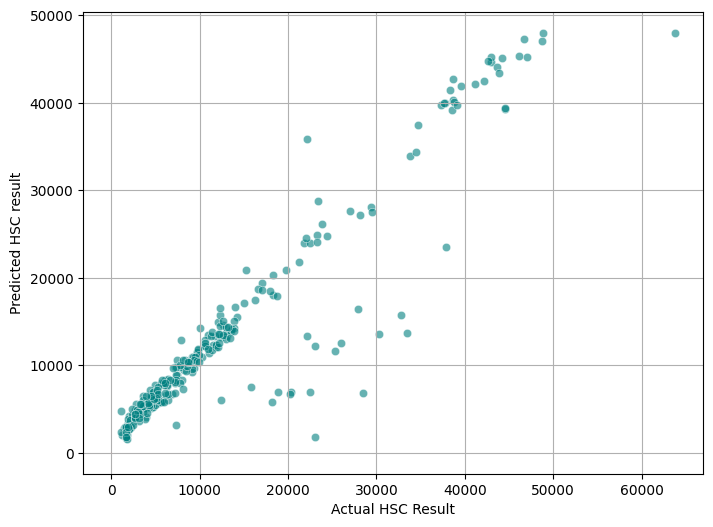

In [26]:
best_model_name = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model_name]

#fit the best model

final_pipe = Pipeline([
    ('preprocessor', preprocess),
    ('model',best_model_obj)
])

final_pipe.fit(X_train,y_train)
y_final_pred = final_pipe.predict(X_test)


#plot Actual vs predicted

plt.figure( figsize = (8,6) )

sns.scatterplot(x=y_test, y=y_final_pred, alpha = 0.6, color='teal' )
plt.plot( [2,5] , [2,5], color = "red", linestyle = '--'  )

plt.xlabel("Actual HSC Result")
plt.ylabel("Predicted HSC result")

plt.grid(True)
plt.show()

In [27]:
# cross validation 5 folds

pipe = Pipeline([
    ("preprocessor", preprocess),
    ("model", best_model_obj)   # gradient boost
])

# MAE (negative in sklearn, so we flip sign)
mae_scores = -cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
print("MAE per fold:", mae_scores)
print("Mean MAE:", mae_scores.mean(), "Std:", mae_scores.std())

MAE per fold: [2551.42107813 2796.8431455  2227.15768811 2473.40708469 2484.46008465]
Mean MAE: 2506.6578162152277 Std: 182.17022094624477


In [28]:
#  Hyperparameter Tuning


gb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

param_dist_gb = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.01, 0.03],
    "model__max_depth": [2, 3, 4, 5],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__max_features": [None, "sqrt", "log2"]
}

search_gb = RandomizedSearchCV(
    gb_pipe,
    param_distributions=param_dist_gb,
    n_iter=50,
    cv=5,
    scoring="neg_mean_absolute_error",   # use MAE (robust)
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_gb.fit(X, y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'bmi', 'children'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unkno...
                                              GradientBoostingRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.03],
                                        'model__max_depth': [2, 3, 4, 5],
                                        'model__max_features': [None, 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': [1, 2, 4, 8],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20],
                                        'model__n_estimators': [100, 200],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [29]:
print("Best GB CV MAE:", -search_gb.best_score_)
print("Best GB params:", search_gb.best_params_)
best_gb = search_gb.best_estimator_


Best GB CV MAE: 2449.2160278528877
Best GB params: {'model__subsample': 0.6, 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 3, 'model__learning_rate': 0.03}


In [30]:
# Model evaluatoion


gb_base = GradientBoostingRegressor(
    random_state=42,
    n_estimators=200,
    learning_rate=0.03,
)

gb_model = TransformedTargetRegressor(
    regressor=gb_base,
    func=np.log1p,
    inverse_func=np.expm1
)

# Wrap to train on log1p(y) but predict in original money
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", gb_model)
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train
gb_pipeline.fit(X_train, y_train)


y_pred = gb_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R2  : {r2:.4f}")

RMSE: 4423.5195
MAE : 1992.4354
R2  : 0.8740
